## Case 1: Underactuated Inverted Pendulum with Reaction Wheel


In [25]:
import sympy as sp
from sympy.physics.mechanics import dynamicsymbols, init_vprinting
from IPython.display import display, Math

init_vprinting()

We'll simplify the problem to one involving a reaction wheel at the top of an inverted pendulum and define our system as follows:

<img src="../../assets/diagrams/case-1.jpg" width=750/>


Next, we'll define the following variables to describe each joint and link in the system.


In [26]:
# Constants
g, t = sp.symbols('g,t')

# Link 1
alpha_1 = 0
b_1 = 0
theta_1 = dynamicsymbols("theta_1")
theta_1d = sp.diff(theta_1, t)
theta_1dd = sp.diff(theta_1d, t)
d_1 = 0

l_1, l_c1 = sp.symbols("l_1 l_c1")
m_1 = sp.symbols("m_1")
I_c1 = sp.Rational(1, 12) * m_1 * l_1**2
# I_c1 = sp.Symbol("I_c1")
# I_c1 = 0

# Link 2
alpha_2 = 0
b_2 = l_1
theta_2 = dynamicsymbols("theta_2")
theta_2d = sp.diff(theta_2, t)
theta_2dd = sp.diff(theta_2d, t)
d_2 = 0

r = sp.Symbol("r")
l_c2 = 0
m_2 = sp.Symbol("m_2")
I_c2 = sp.Rational(1, 2) * m_2 * r**2
# I_c2 = sp.Symbol("I_c2")


We can then calculate the transformation matrices for the different frames to the base frame.


In [27]:
T_01 = sp.simplify(sp.Matrix([
    [sp.cos(theta_1), -sp.sin(theta_1), 0, b_1],  # type: ignore
    [sp.cos(alpha_1) * sp.sin(theta_1), sp.cos(alpha_1) * sp.cos(theta_1), -sp.sin(alpha_1), -d_1 * sp.sin(alpha_1)],  # type: ignore
    [sp.sin(alpha_1) * sp.sin(theta_1), sp.sin(alpha_1) * sp.cos(theta_1), sp.cos(alpha_1), d_1 * sp.cos(alpha_1)],  # type: ignore
    [0, 0, 0, 1]
]))

T_12 = sp.simplify(sp.Matrix([
    [sp.cos(theta_2), -sp.sin(theta_2), 0, b_2],  # type: ignore
    [sp.cos(alpha_2) * sp.sin(theta_2), sp.cos(alpha_2) * sp.cos(theta_2), -sp.sin(alpha_2), -d_2 * sp.sin(alpha_2)],  # type: ignore
    [sp.sin(alpha_2) * sp.sin(theta_2), sp.sin(alpha_2) * sp.cos(theta_2), sp.cos(alpha_2), d_2 * sp.cos(alpha_2)],  # type: ignore
    [0, 0, 0, 1]
]))

T_02 = sp.simplify(T_01 * T_12)

R_01 = T_01[:3, :3]
R_12 = T_12[:3, :3]
R_02 = T_02[:3, :3]

D_01 = T_01[:3, 3]
D_12 = T_12[:3, 3]

D_1c1 = sp.Matrix([l_c1, 0, 0]).reshape(3, 1)

D_1c2 = D_12

D_2c2 = sp.Matrix([l_c2, 0, 0]).reshape(3, 1)


In [28]:
display(Math(f"T_0^1 = {sp.latex(T_01)}"))
display(Math(f"T_1^2 = {sp.latex(T_12)}"))
display(Math(f"T_0^2 = {sp.latex(T_02)}"))

display(Math(f"R_0^1 = {sp.latex(R_01)}"))
display(Math(f"R_1^2 = {sp.latex(R_12)}"))
display(Math(f"R_0^2 = {sp.latex(R_02)}"))

display(Math(f"D_1^{{c1}} = {sp.latex(D_1c1)}"))
display(Math(f"D_1^{{c2}} = {sp.latex(D_1c2)}"))
display(Math(f"D_2^{{c2}} = {sp.latex(D_2c2)}"))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Now, we can calculate the Jacobians for the system. Note that we're mainly concerned about the center of mass for every link, so the D vector refers to the distances to the center of mass of each link.


In [29]:
J_v1 = sp.simplify(sp.Matrix.hstack(
    R_01[:, 2].cross(R_01 * D_1c1),
    sp.zeros(3, 1)
))

J_v2 = sp.simplify(sp.Matrix.hstack(
    R_01[:, 2].cross(R_01 * D_1c2),
    R_02[:, 2].cross(R_02 * D_2c2)
))

J_omega1 = sp.simplify(sp.Matrix.hstack(
    R_01[:, 2],
    sp.zeros(3, 1)
))

J_omega2 = sp.simplify(sp.Matrix.hstack(
    R_01[:, 2],
    R_02[:, 2]
))


In [30]:
display(Math(f"J_{{v1}} = {sp.latex(J_v1)}"))
display(Math(f"J_{{v2}} = {sp.latex(J_v2)}"))

display(Math(f"J_{{v1}}^T J_{{v1}} = {sp.latex(J_v1.T * J_v1)}"))

display(Math(f"J_{{\\omega1}} = {sp.latex(J_omega1)}"))
display(Math(f"J_{{\\omega2}} = {sp.latex(J_omega2)}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Using the moment of inertias for the system and the Jacobians, we'll calculate the required torque vector.


In [31]:
M = sp.simplify(
    (m_1 * J_v1.T * J_v1 + J_omega1.T * sp.diag(I_c1, I_c1, I_c1) * J_omega1) +
    (m_2 * J_v2.T * J_v2 + J_omega2.T * sp.diag(I_c2, I_c2, I_c2) * J_omega2)
)
M_d = sp.simplify(M.diff(t))

Q = sp.Matrix([theta_1, theta_2]).reshape(2, 1)
Q_d = Q.diff(t)
Q_dd = Q_d.diff(t)

V = sp.simplify((M_d * Q_d) - sp.Rational(1, 2) * sp.Matrix.vstack(
    Q_d.T * M.diff(theta_1) * Q_d,
    Q_d.T * M.diff(theta_2) * Q_d
))

P = sp.simplify((m_1 * l_c1 + m_2 * l_1) * g * sp.sin(theta_1))

G = sp.simplify(sp.Matrix([
    P.diff(theta_1),
    P.diff(theta_2)
]).reshape(2, 1))

T = sp.simplify(M * Q_dd + V + G)


In [32]:
display(Math("M \\ddot{Q} + V + G = T"))

display(Math(f"M = {sp.latex(M)}"))
display(Math(f"\\dot{{M}} = {sp.latex(M_d)}"))

display(Math(f"Q = {sp.latex(Q)}"))
display(Math(f"\\dot{{Q}} = {sp.latex(Q_d)}"))
display(Math(f"\\ddot{{Q}} = {sp.latex(Q_dd)}"))

display(Math(f"V = {sp.latex(V)}"))

display(Math(f"G = {sp.latex(G)}"))

display(Math(f"T = {sp.latex(T)}"))

print(sp.latex(T))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

\left[\begin{matrix}g \left(l_{1} m_{2} + l_{c1} m_{1}\right) \cos{\left(\theta_{1}{\left(t \right)} \right)} + \frac{m_{2} r^{2} \frac{d^{2}}{d t^{2}} \theta_{2}{\left(t \right)}}{2} + \frac{\left(l_{1}^{2} m_{1} + 12 l_{1}^{2} m_{2} + 12 l_{c1}^{2} m_{1} + 6 m_{2} r^{2}\right) \frac{d^{2}}{d t^{2}} \theta_{1}{\left(t \right)}}{12}\\\frac{m_{2} r^{2} \left(\frac{d^{2}}{d t^{2}} \theta_{1}{\left(t \right)} + \frac{d^{2}}{d t^{2}} \theta_{2}{\left(t \right)}\right)}{2}\end{matrix}\right]


# Forward Dynamics

In [33]:
tau = sp.symbols('tau')
system = [sp.Eq(T[0], 0), sp.Eq(T[1], tau)]
sol = sp.solve(system, [theta_1dd, theta_2dd])


In [34]:
display(Math(f"\\ddot{{\\theta_1}} = {sp.latex(sp.simplify(sol[theta_1dd]))}"))
display(Math(f"\\ddot{{\\theta_2}} = {sp.latex(sp.simplify(sol[theta_2dd]))}"))

# f = sp.lambdify((theta_1, theta_1d, theta_2, theta_2d, tau), sol[theta_2dd])

print(sp.simplify(sol[theta_1dd]))
print(sp.simplify(sol[theta_2dd]))



<IPython.core.display.Math object>

<IPython.core.display.Math object>

-(12*g*l_1*m_2*cos(theta_1(t)) + 12*g*l_c1*m_1*cos(theta_1(t)) + 12*tau)/(l_1**2*m_1 + 12*l_1**2*m_2 + 12*l_c1**2*m_1)
2*(6*g*l_1*m_2**2*r**2*cos(theta_1(t)) + 6*g*l_c1*m_1*m_2*r**2*cos(theta_1(t)) + l_1**2*m_1*tau + 12*l_1**2*m_2*tau + 12*l_c1**2*m_1*tau + 6*m_2*r**2*tau)/(m_2*r**2*(l_1**2*m_1 + 12*l_1**2*m_2 + 12*l_c1**2*m_1))


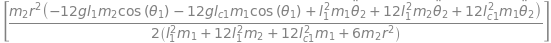

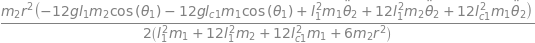

In [35]:
v = sp.solve(sp.Eq(theta_2dd, sol[theta_2dd]), tau)

display(v)
display(sp.simplify(v[0]))